In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [12]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams['figure.dpi'] = 500

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
nbar = [0.001, 0.01]
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8

# Mocks
nmocks = [100, 10]

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Gaussian mocks to compare to model

In [4]:
output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
name = ['{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(nmocks[i], z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

## Initialize Gaussian model

In [5]:
model = [SplitCCFModel(redshift=z, cosmology=cosmology, bias=bias, nbar=nb) for nb in nbar]

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/main/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


## $\delta_R$

FileNotFoundError: [Errno 2] No such file or directory: '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/100gaussianMocks_pkdamped_z1.175_bias1.8_boxsize2000_nmesh1024_nbar0.001_cellsize10_resamplertsc_delta_R.npy'

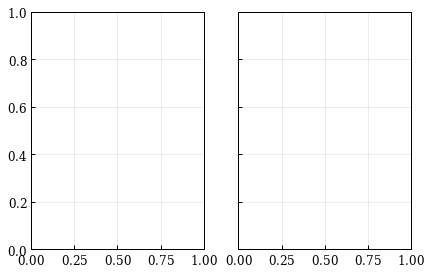

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)

delta = np.linspace(-3, 3, 100)

for i, nb in enumerate(nbar):
    ## Mocks
    densities = np.load(output_dir+name[i]+'_delta_R.npy')

    ## Model
    model_density_no_shot_noise = scipy.stats.norm.pdf(delta, 0, model[i].sigma_RR)
    model_density_gaussian_shot_noise = model[i].density_with_shot_noise(delta, p=2)
    model_density_full_shot_noise = model[i].density_with_shot_noise(delta, p=4)

    axes[i].hist(np.ravel(densities), bins=100, density=True, alpha=0.5, label = r'Mocks')
    axes[i].plot(delta, model_density_no_shot_noise, label='No shot noise', ls=':', color='orangered')
    axes[i].plot(delta, model_density_gaussian_shot_noise, label='Gaussian shot noise', ls='--', color='darkcyan')
    axes[i].plot(delta, model_density_full_shot_noise, label='Full shot noise', ls='-', color='darkcyan')
    axes[i].set_xlabel(r'$\delta_R$')
    axes[i].set_title(r'$\bar{{n}}$ = {:.3f} [$(h/\mathrm{{Mpc}})^3$]'.format(nb))
    
axes[1].legend()
#plt.savefig('/feynman/home/dphp/mp270220/plots/gaussianModelvsMocks_deltaR.png', dpi=1000)
plt.show()

## $\xi_{R}(s)$

In [53]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

ells = [0]
nells = len(ells)

In [54]:
xi_R_list = list()

for nb in nbar:
    xi_R_result = list()
    
    for batch_index in range(10):
        batch_size = 10
        name_temp = '{:d}gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}'.format(batch_size, batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler)
        batch_results = np.load(output_dir+name_temp+'_xi_R.npy', allow_pickle=True)
        for batch in batch_results:
            xi_R_result.append(batch)
    
    xi_R_list.append(xi_R_result)

In [57]:
nmocks = [100, 100]

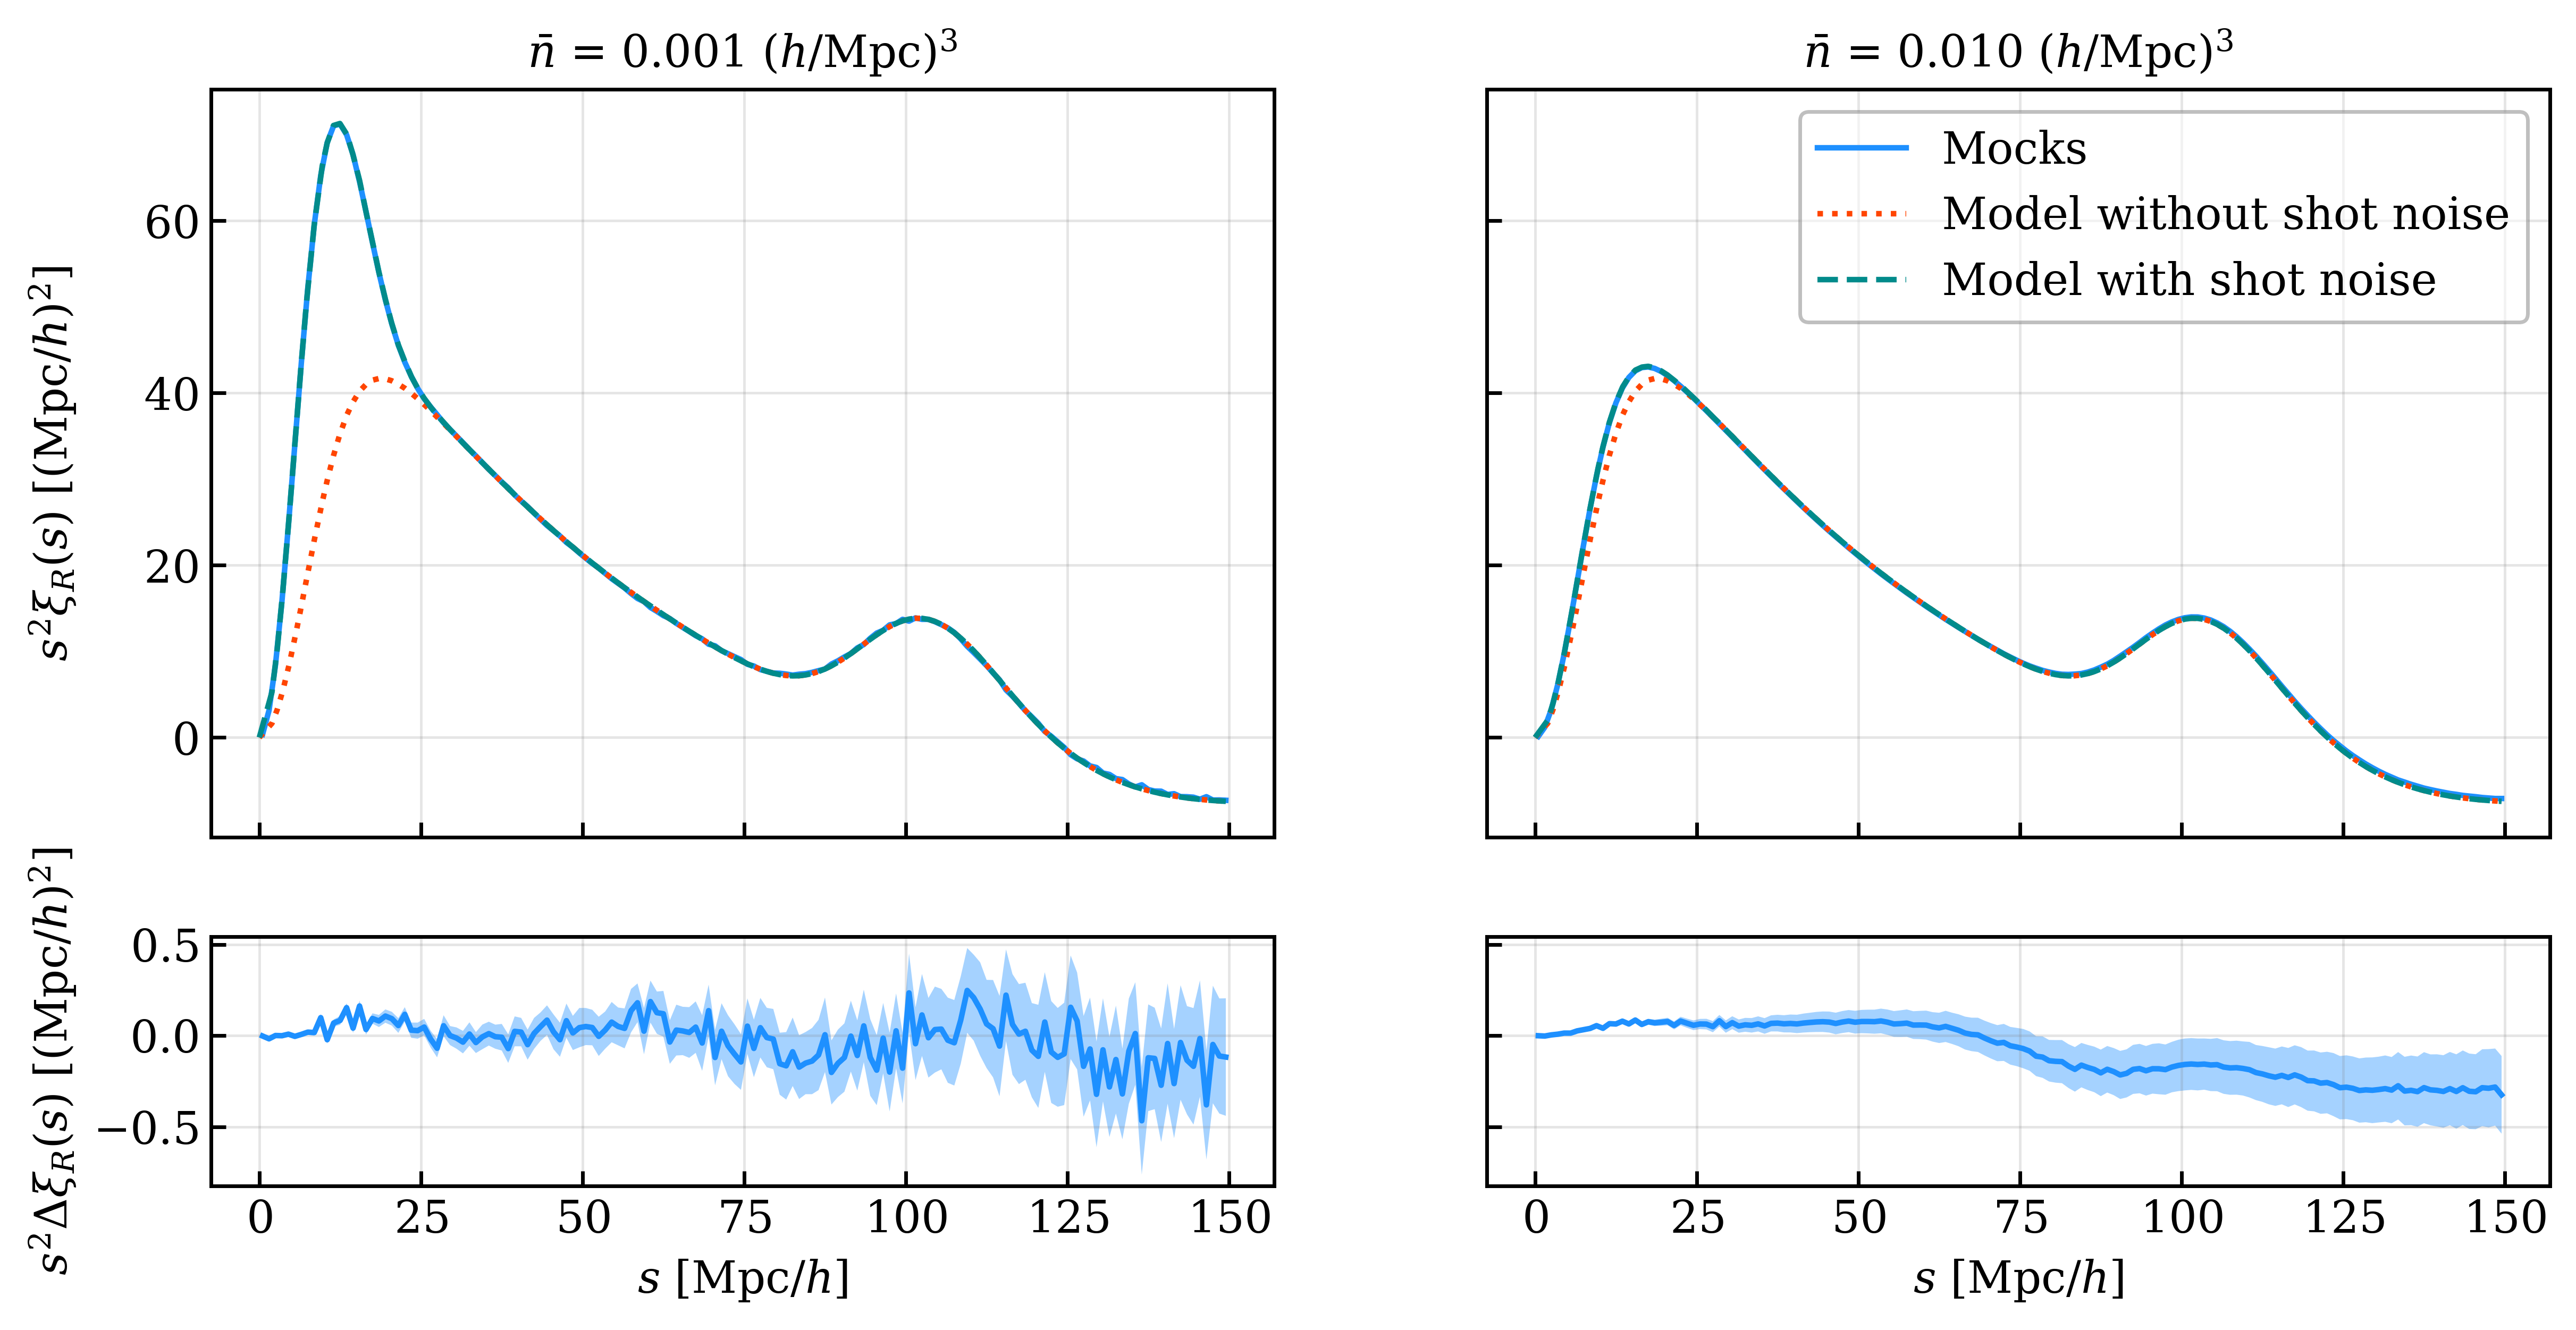

In [72]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

for i, nb in enumerate(nbar):
    ## Mocks
    #xi_R = np.load(output_dir+name[i]+'_xi_R.npy', allow_pickle=True)
    xi_R = xi_R_list[i]
    mocks_xi_R_ells, cov = get_poles(xi_R, ells)
    std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(nmocks[i])
    s, _, res = xi_R[0].get_corr(return_sep=True)
    
    ## Model
    model_xiR_no_shot_noise = model[i].xi_R
    model_xiR_with_shot_noise = model[i].xi_R_with_shot_noise

    for ill, ell in enumerate(ells):
        y = s**2 * mocks_xi_R_ells[ill]
        error = s**2 * std[ill]
    
        axes[0][i].plot(s, y, label='Mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[0][i].fill_between(s, y-error, y+error, alpha=0.4)
        axes[0][i].plot(model[i].sep, model[i].sep**2 * model_xiR_no_shot_noise, label=r'Model without shot noise', ls=':')
        axes[0][i].plot(model[i].sep, model[i].sep**2 * model_xiR_with_shot_noise, label=r'Model with shot noise', ls='--')
        #axes[i].plot(model[i].sep, model[i].sep**2 * nb * (model_xiR_with_shot_noise + w[0] / nb * (1 + model[i].xi)) / (w[0] + nb), label=r'Model with shot noise (corrected)', ls='--')
        axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
        
        model_interp = scipy.interpolate.interp1d(model[i].sep.transpose()[0], model[i].xi_R_with_shot_noise.transpose()[0])
        y_err = s**2 * (model_interp(s) - mocks_xi_R_ells[ill])
        axes[1][i].plot(s, y_err, label='Mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[1][i].fill_between(s, y_err-error, y_err+error, alpha=0.4)
        axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
axes[0][1].legend()
plt.savefig('/feynman/home/dphp/mp270220/plots/gaussianModelvs200Mocks_xiR.png', dpi=1000)
plt.show()

In [65]:
for i, nb in enumerate(nbar):
#    for j in range(nmocks[i]):
#        xi_R_list[i][j].rebin(factor=(5, 1))

    xi_R = xi_R_list[i]
    mocks_xi_R_ells, cov = get_poles(xi_R, ells)
    s, _, res = xi_R[0].get_corr(return_sep=True)
    print(s)
    s_lower_limit = 25
    s, xiell, cov = truncate_xiell(s_lower_limit, s, mocks_xi_R_ells, ells, cov)

    model_interp = scipy.interpolate.interp1d(model[i].sep.transpose()[0], model[i].xi_R_with_shot_noise.transpose()[0])
    #print(np.linalg.inv(cov).dot(cov))
    diff = xiell.flatten()-model_interp(s)
    chi2 = compute_chisq(xiell.flatten(), cov/nmocks[i], model_interp(s))
    print(chi2/len(s))

[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5]
1.5615526032007834
[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5]
10.877356406117041


## $\xi_R^{DS}$

In [28]:
nsplits = 3
randoms_size = 4
th_bins = np.array([-np.inf, -0.21875857,  0.21875857, np.inf])

In [29]:
results = list()

for i, nb in enumerate(nbar):
    result = list()
    
    if i==0:
        for batch_index in range(10):
            name_temp = '10gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
            batch_results = np.load(output_dir+name_temp+'_RH_CCF.npy', allow_pickle=True)
            for batch in batch_results:
                result.append(batch)
                
    else:
        for batch_index in range(10):
            name_temp = 'gaussianMock{}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
            batch_results = np.load(output_dir+name_temp+'_RH_CCF.npy', allow_pickle=True)
            for batch in batch_results:
                result.append(batch)
    results.append(result)
        

In [31]:
for i, nb in enumerate(nbar):
    model[i].smoothed_density_moments()

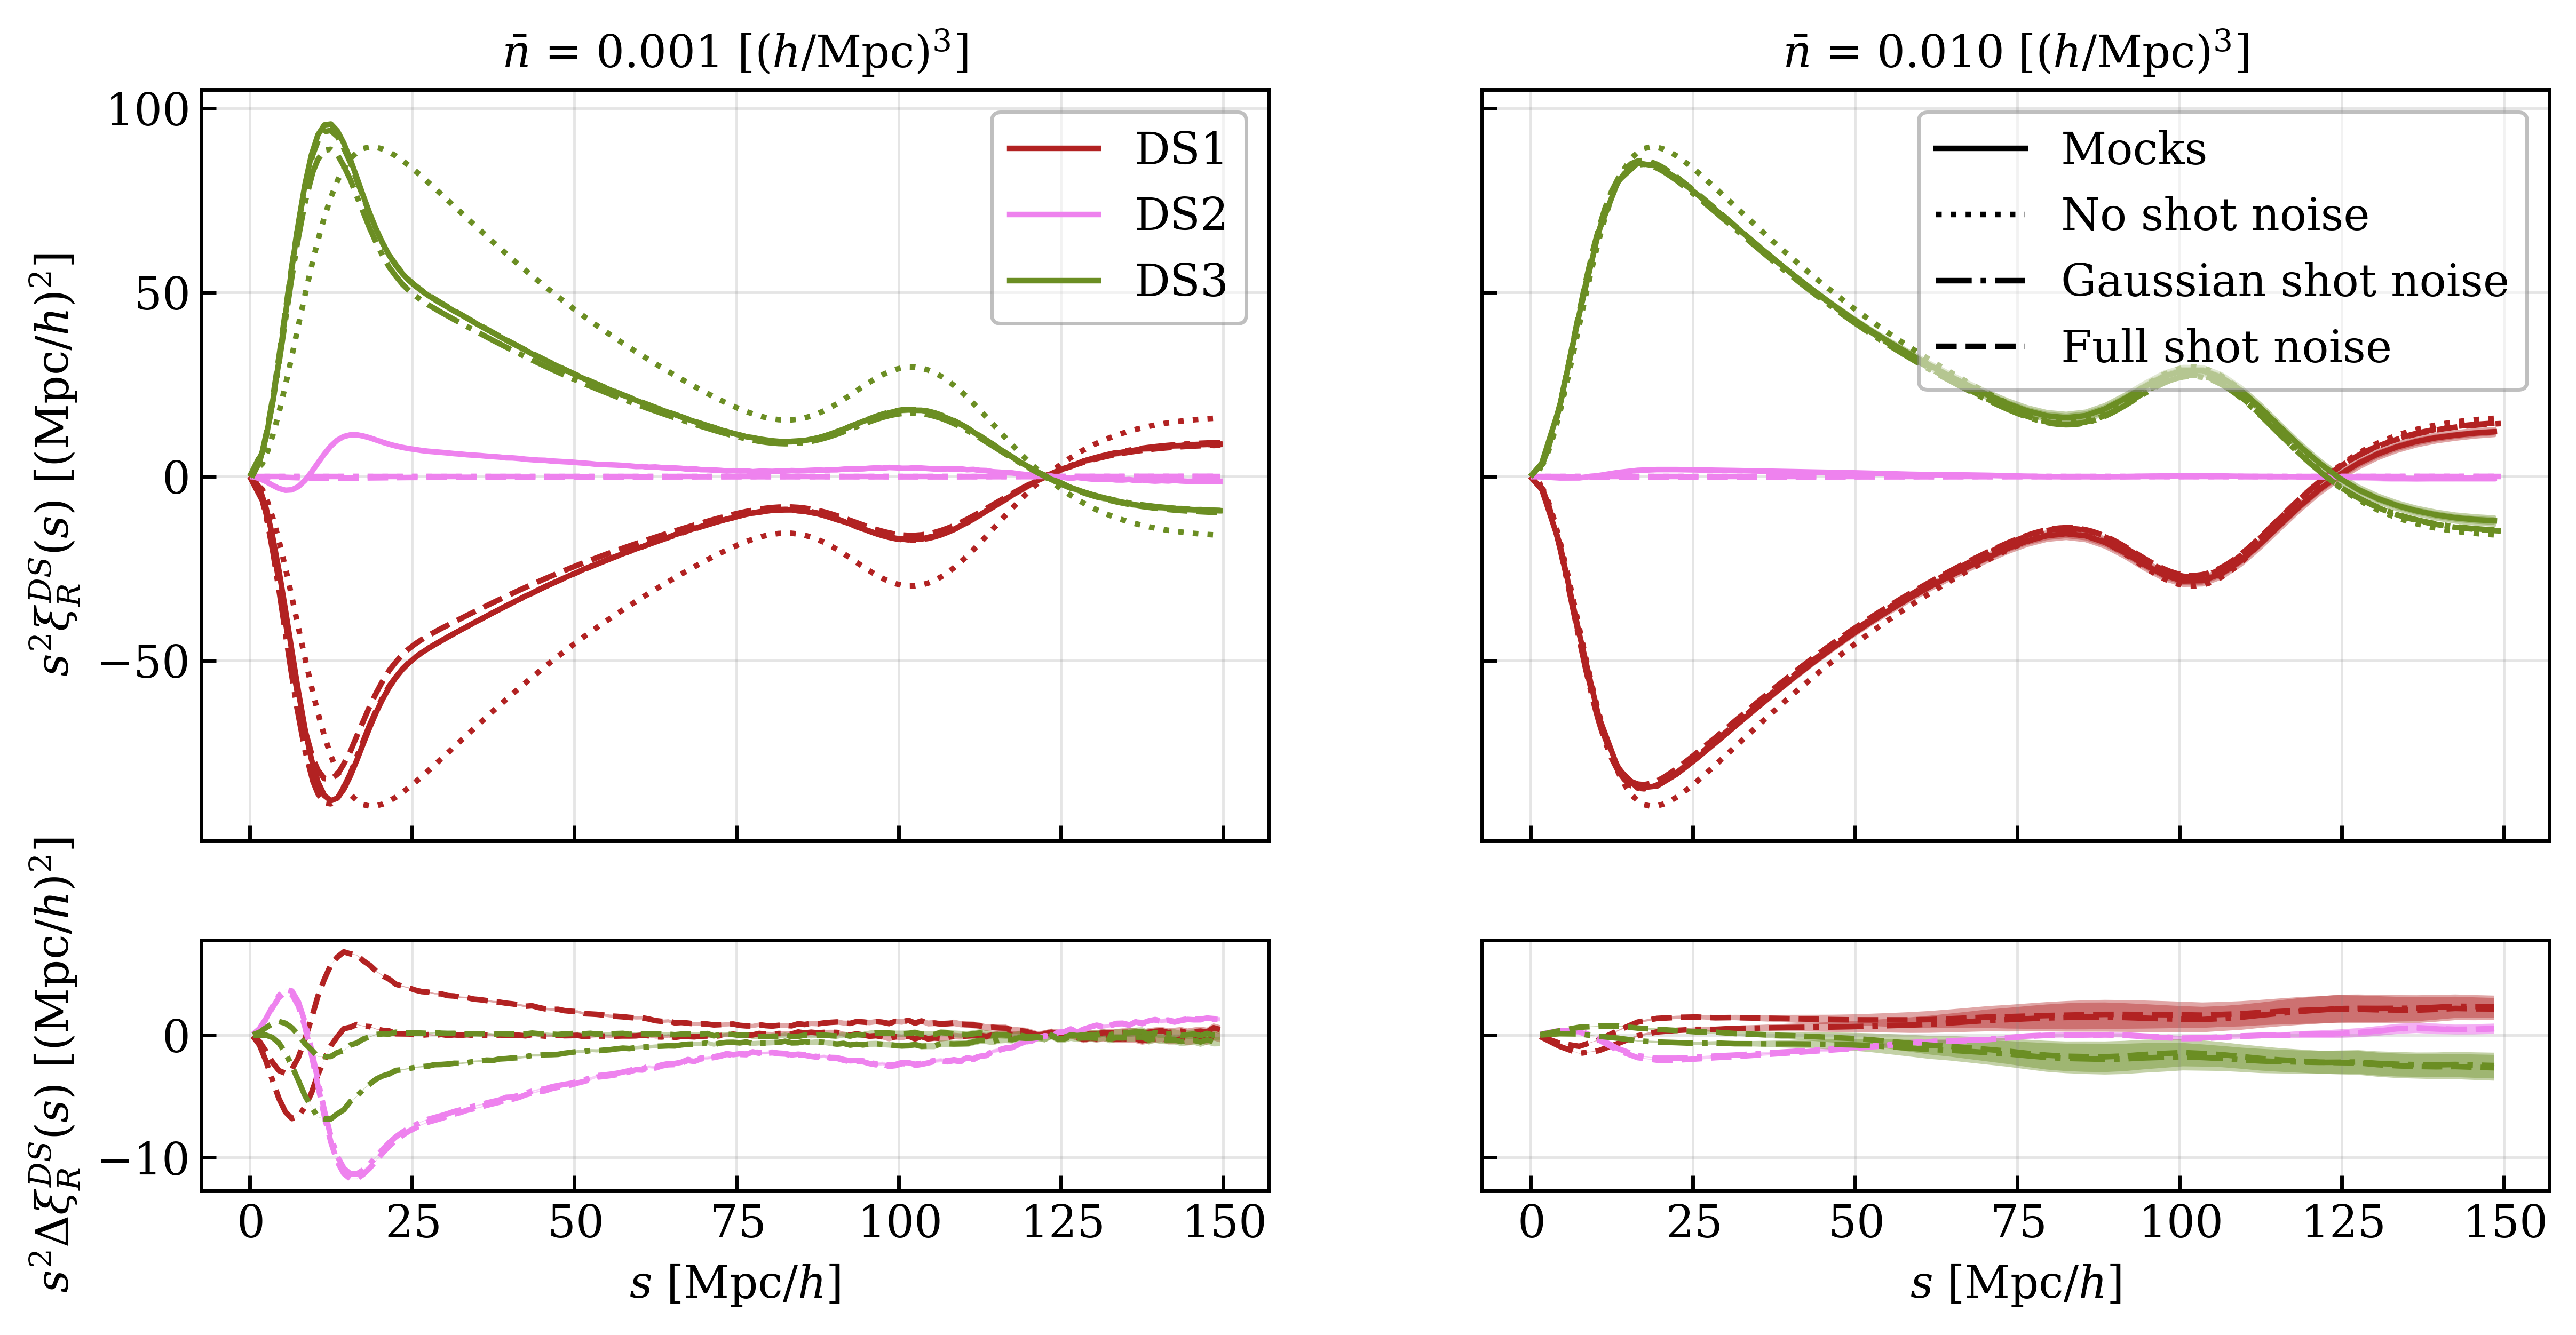

In [49]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

for i, nb in enumerate(nbar):
    ## Mocks
    split_xi = results[i]
    mocks_split_xi_rh, cov_rh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
    s, _, res = results[i][0][0].get_corr(return_sep=True)
    
    ## Model
    ccf_RH_no_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins)
    ccf_RH_gaussian_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=2)
    ccf_RH_with_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)
    
    colors = ['firebrick', 'violet', 'olivedrab']
    
    for ill, ell in enumerate(ells):
        for ds in range(nsplits):
            y = s**2 * mocks_split_xi_rh[ds][ill]
            error = s**2 * std_rh[ds][ill]

            axes[0][i].plot(s, y, color=colors[ds])
            axes[0][i].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_no_shot_noise[ds], ls=':', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_gaussian_shot_noise[ds], ls='-.', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_with_shot_noise[ds], ls='--', color=colors[ds])
            axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} [$(h/\mathrm{{Mpc}})^3$]'.format(nb))
            
            model_interp_gaussian_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_RH_gaussian_shot_noise[ds].transpose()[0])
            y_err_gaussian_shot_noise = s**2 * (model_interp_gaussian_shot_noise(s) - mocks_split_xi_rh[ds][ill])
            model_interp_with_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_RH_with_shot_noise[ds].transpose()[0])
            y_err_with_shot_noise = s**2 * (model_interp_with_shot_noise(s) - mocks_split_xi_rh[ds][ill])
            axes[1][i].plot(s, y_err_gaussian_shot_noise, label='Mocks', ls='-.', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_gaussian_shot_noise-error, y_err_gaussian_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].plot(s, y_err_with_shot_noise, label='Mocks', ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_with_shot_noise-error, y_err_with_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

for ds in range(nsplits):
    axes[0][0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
axes[0][1].plot([], [], ls='-', color='black', label='Mocks')
axes[0][1].plot([], [], ls=':', color='black', label='No shot noise')
axes[0][1].plot([], [], ls='-.', color='black', label='Gaussian shot noise')
axes[0][1].plot([], [], ls='--', color='black', label='Full shot noise')
axes[0][0].legend()
axes[0][1].legend()

axes[0][0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#plt.savefig('/feynman/home/dphp/mp270220/plots/gaussianModelvsMocks_densitysplits.png', dpi=1000)
plt.show()

In [81]:
for i, nb in enumerate(nbar):
    split_xi = results[i]
    mocks_split_xi_rh, cov_rh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    s, _, res = split_xi[0][0].get_corr(return_sep=True)
    s_lower_limit = 25
    s, xiell, cov = truncate_xiell(s_lower_limit, s, mocks_split_xi_rh, ells, cov_rh, split=True, nsplits=nsplits)

    model_interp = np.array([scipy.interpolate.interp1d(model[i].sep.transpose()[0], model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)[j].transpose()[0]) for j in range(nsplits)])
    chi2 = compute_chisq(xiell.flatten(), cov/nmocks[i], np.array([model_interp[j](s) for j in range(nsplits)]).flatten())
    print(chi2/len(s))

103.64065452538752
-1149261059830446.5


### Compute each component of the model from mocks

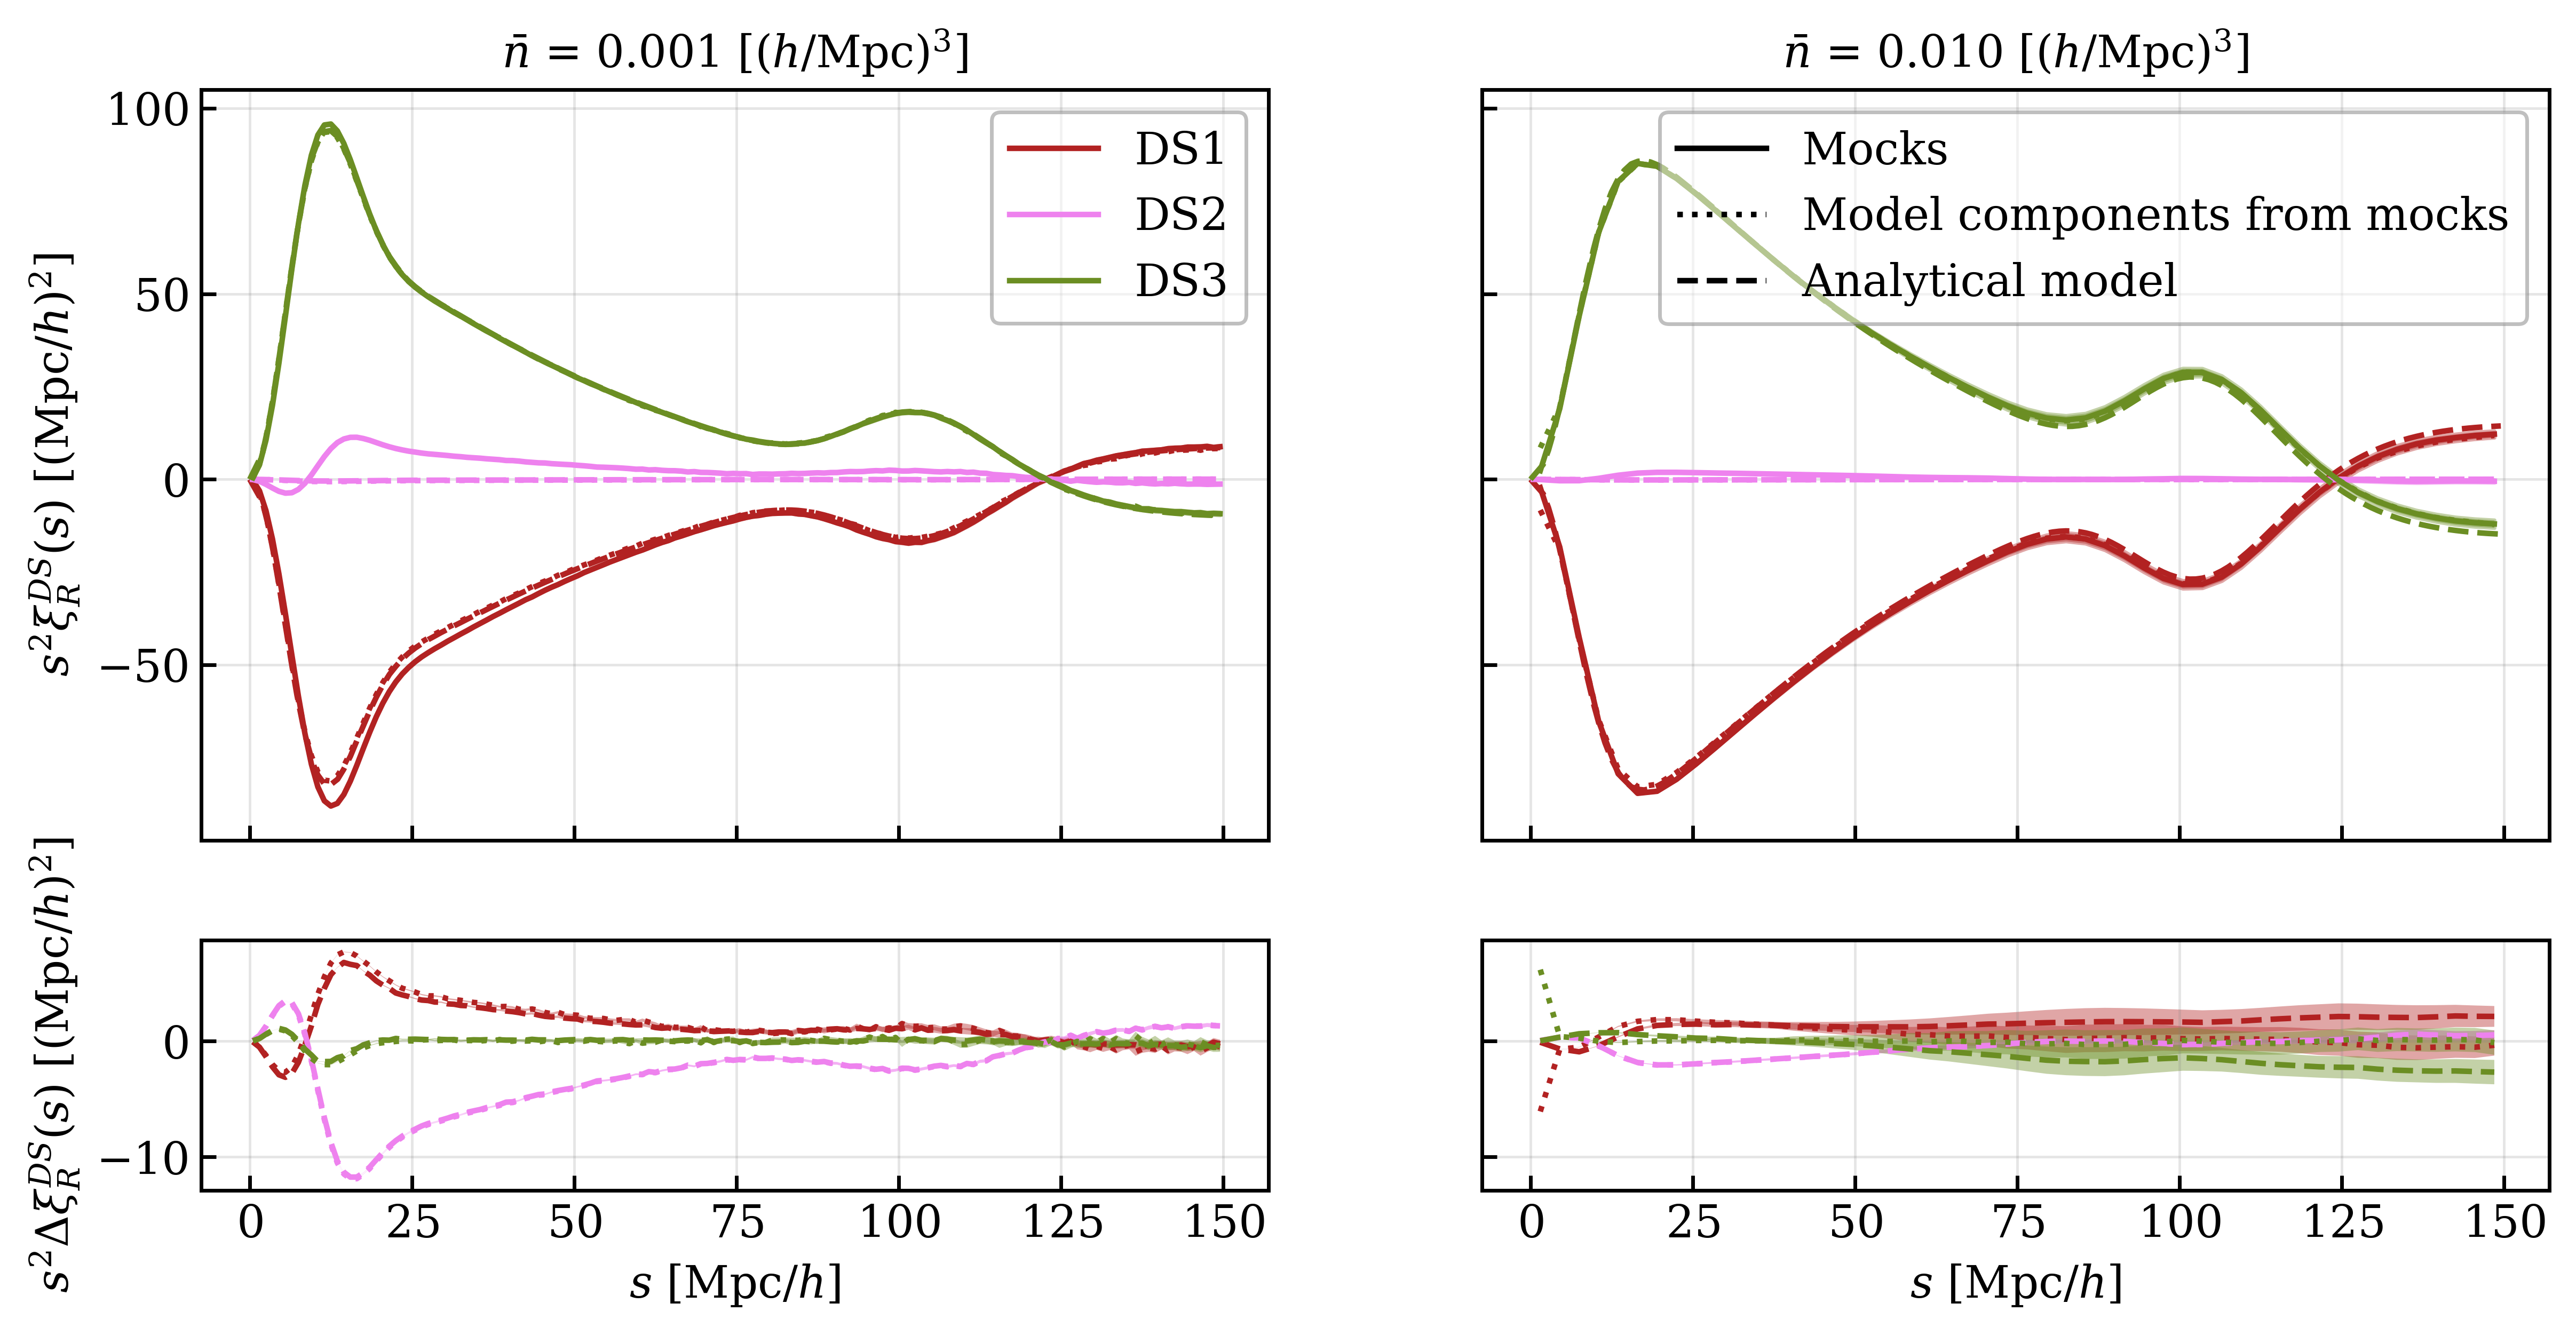

In [50]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

name = ['10gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

for i, nb in enumerate(nbar):
    ## Mocks
    split_xi = results[i]
    mocks_split_xi_rh, cov_rh = get_split_poles(split_xi, ells=ells, nsplits=nsplits)
    std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks[i])
    
    output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
    xi_R = xi_R_list[i]
    mocks_xi_R_ells, cov = get_poles(xi_R, ells)
    output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
    densities = np.load(output_dir+name[i]+'_delta_R.npy')
    sigma_RR = np.std(densities)
    
    ccf_RH_with_shot_noise = model[i].ccf_randoms_tracers(density_bins=th_bins, shot_noise=True, p=4)
    
    colors = ['firebrick', 'violet', 'olivedrab']
    
    for ill, ell in enumerate(ells):
        for ds in range(nsplits):
            s, _, res = results[i][0][0].get_corr(return_sep=True)
            y = s**2 * mocks_split_xi_rh[ds][ill]
            error = s**2 * std_rh[ds][ill]
            
            d1 = th_bins[ds]
            d2 = th_bins[ds+1]
            split = np.logical_and((densities > d1), (densities <= d2))
            split_densities = densities[split]
            delta_tilde = np.mean(split_densities)
            split_model = mocks_xi_R_ells[ill] * delta_tilde / sigma_RR**2
            
            axes[0][i].plot(s, y, color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[0][i].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
            s, _, res = xi_R[0].get_corr(return_sep=True)
            axes[0][i].plot(s, s**2 * split_model, ls=':', color=colors[ds])
            axes[0][i].plot(model[i].sep, model[i].sep**2 * ccf_RH_with_shot_noise[ds], ls='--', color=colors[ds])
            axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} [$(h/\mathrm{{Mpc}})^3$]'.format(nb))
            
            model_interp_with_shot_noise = scipy.interpolate.interp1d(model[i].sep.transpose()[0], ccf_RH_with_shot_noise[ds].transpose()[0])
            y_err_with_shot_noise = s**2 * (model_interp_with_shot_noise(s) - mocks_split_xi_rh[ds][ill])
            axes[1][i].plot(s, s**2 * split_model - y, label='Mocks', ls=':', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, s**2 * split_model - y-error, s**2 * split_model - y+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].plot(s, y_err_with_shot_noise, label='Mocks', ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_with_shot_noise-error, y_err_with_shot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

for ds in range(nsplits):
    axes[0][0].plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
axes[0][1].plot([], [], ls='-', color='black', label='Mocks')
axes[0][1].plot([], [], ls=':', color='black', label='Model components from mocks')
axes[0][1].plot([], [], ls='--', color='black', label='Analytical model')
axes[0][0].legend()
axes[0][1].legend()

#plt.savefig('/feynman/home/dphp/mp270220/plots/gaussianModelvsMocks_denistysplits.png', dpi=1000)
plt.show()